<a href="https://colab.research.google.com/github/Whizzion957/DAI101-Assignment-DataAnalysis/blob/main/Assignment_DAI101_Aadit_23114001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment DAI-101 Aadit - 23114001

In [81]:
#Importing Libraries
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

###Task - 01 Data Cleaning

In [82]:
#The CSV file is downoaded from Kaggle and stored in Google Drive, the link is attached.
#Kaggle Link:- https://www.kaggle.com/datasets/mohammedarfathr/customer-transactions-dataset/data
#The Google Drive Share link is converted to exportable and downloadable form

#Loading the dataset
DB=pd.read_csv("https://drive.google.com/uc?export=download&id=15OViD4yxYIQVDQbhhF1IGbtlY67Yvwtj")
print(DB.head()) #Checking if data is correctle loaded.
print()
print(f"The dimensions of the data matrix are: " + str(DB.shape)) #(Rows, Columns)


   Customer_ID   Age  Annual_Income  Spending_Score  Purchase_Frequency  \
0         8270  31.0   75851.592212       77.104268                  17   
1         1860  48.0   44460.183764       61.349076                  25   
2         6390  17.0   43677.755605       22.589956                   9   
3         6191  34.0   48666.812544       82.069525                   0   
4         6734  44.0   46080.334029       65.076915                   3   

   Transaction_Amount  
0          129.724190  
1           91.479265  
2          130.573812  
3           72.395846  
4          156.399077  

The dimensions of the data matrix are: (10200, 6)


In [83]:
#Handling missing values
#All operation are inplace
#If column data is categorical fill with mode, otherwise with mean

null_count = DB["Customer_ID"].isna().sum()
print(f"Number of missing (NaN) values in Customer_ID: {null_count}") #It is zero

fill_values = {}
for column in DB.columns:
  if DB[column].dtype=="object":
    fill_values[column]=DB[column].mode()[0]
  else:
    fill_values[column]=DB[column].mean()
DB.fillna(fill_values, inplace=True)


#Identifying and remove duplicate records
#Remove duplicate rows which have all the attributes same as of another row
#Count duplicates bofore and after removal
#Check dataset shape after removal
print(f"Duplicate rows before removal: {DB.duplicated().sum()}")
DB=DB.drop_duplicates()
print(f"Duplicate rows after removal: {DB.duplicated().sum()}")
print(f"New dataset shape: {DB.shape}")

#Treating Inconsistent Data
#If transaction amount * purchase frequency > salary then this is a contracdiction. This can happen after filling missing values, or due to filling errors
condition=(DB["Purchase_Frequency"]*DB["Transaction_Amount"])>DB["Annual_Income"]
#Count inconsistent rows
inconsistent_count=condition.sum()
print(f"Number of inconsistent rows: {inconsistent_count}")
DB = DB[~condition]
print(f"New dataset shape: {DB.shape}")

Number of missing (NaN) values in Customer_ID: 0
Duplicate rows before removal: 200
Duplicate rows after removal: 0
New dataset shape: (10000, 6)
Number of inconsistent rows: 10
New dataset shape: (9990, 6)


In [84]:
#Detecting and treating outliers by IQR method and Z-Score
num_col = ["Age", "Annual_Income", "Spending_Score", "Purchase_Frequency", "Transaction_Amount"]
#IQR Method
def remove_outliers_iqr(df, columns):
  cleaned_df=df.copy()
  for col in columns:
    Q1=cleaned_df[col].quantile(0.25)  #First quartile (25%)
    Q3=cleaned_df[col].quantile(0.75)  #Third quartile (75%)
    IQR=Q3-Q1  #Interquartile Range(IQR)
    lower_bound=Q1-1.5*IQR  #Lower Whisker
    upper_bound=Q3+1.5*IQR  #Upper Whisker
    #Filter out outliers
    cleaned_df=cleaned_df[(cleaned_df[col]>=lower_bound) & (cleaned_df[col]<=upper_bound)]
  return cleaned_df

#Z-Score method
#Filter out rows where absolute Z-score>threshold
def remove_outliers_zscore(df, columns, threshold=3):
  cleaned_df = df.copy()
  for col in columns:
    mean = cleaned_df[col].mean()
    std = cleaned_df[col].std()
    z_scores=(cleaned_df[col]-mean)/std
    cleaned_df=cleaned_df[np.abs(z_scores) < threshold]
  return cleaned_df

DB_IQR=remove_outliers_iqr(DB,num_col)
DB_ZSCORE=remove_outliers_zscore(DB,num_col)
print(f"Original dataset shape: {DB.shape}")
print(f"Shape after IQR outlier removal: {DB_IQR.shape}")
print(f"Shape after Z-Score outlier removal: {DB_ZSCORE.shape}")


Original dataset shape: (9990, 6)
Shape after IQR outlier removal: (9777, 6)
Shape after Z-Score outlier removal: (9912, 6)


In [85]:
#Customer ID column can be considered as a categorical Data
#I gave a categorical value analysis for a general column
#Remove special characters (if IDs should be purely alphanumeric) Used REGEX
DB["Customer_ID"] = DB["Customer_ID"].astype(str)
DB["Customer_ID"] = DB["Customer_ID"].str.strip().str.upper()  # Use `.lower()` if needed
DB["Customer_ID"] = DB["Customer_ID"].str.replace(r"[^A-Za-z0-9]","",regex=True)
print(DB["Customer_ID"].head(10))

0    8270
1    1860
2    6390
3    6191
4    6734
5    7265
6    1466
7    5426
8    6578
9    9322
Name: Customer_ID, dtype: object


###Task - 02 Exploratory Data Analysis(EDA)

UNIVARIATE ANALYSIS


 Summary Statistics without outlier analysis:
                      count          mean           std          min  \
Age                 9990.0     34.442852      9.848767     0.000000   
Annual_Income       9990.0  50183.084654  14840.099213  1940.910468   
Spending_Score      9990.0     50.599972     28.618782     1.009234   
Purchase_Frequency  9990.0     14.503103      8.663550     0.000000   
Transaction_Amount  9990.0    100.231898     49.221976   -86.593231   

                             25%           50%           75%            max  \
Age                    28.000000     34.458212     41.000000      69.000000   
Annual_Income       40036.144747  50169.036389  60339.919495  112218.425755   
Spending_Score         26.105996     50.310261     75.588028      99.990069   
Purchase_Frequency      7.000000     15.000000     22.000000      29.000000   
Transaction_Amount     67.195276    100.190612    132.823994     273.518342   

                           mode  skewness  kurtosi

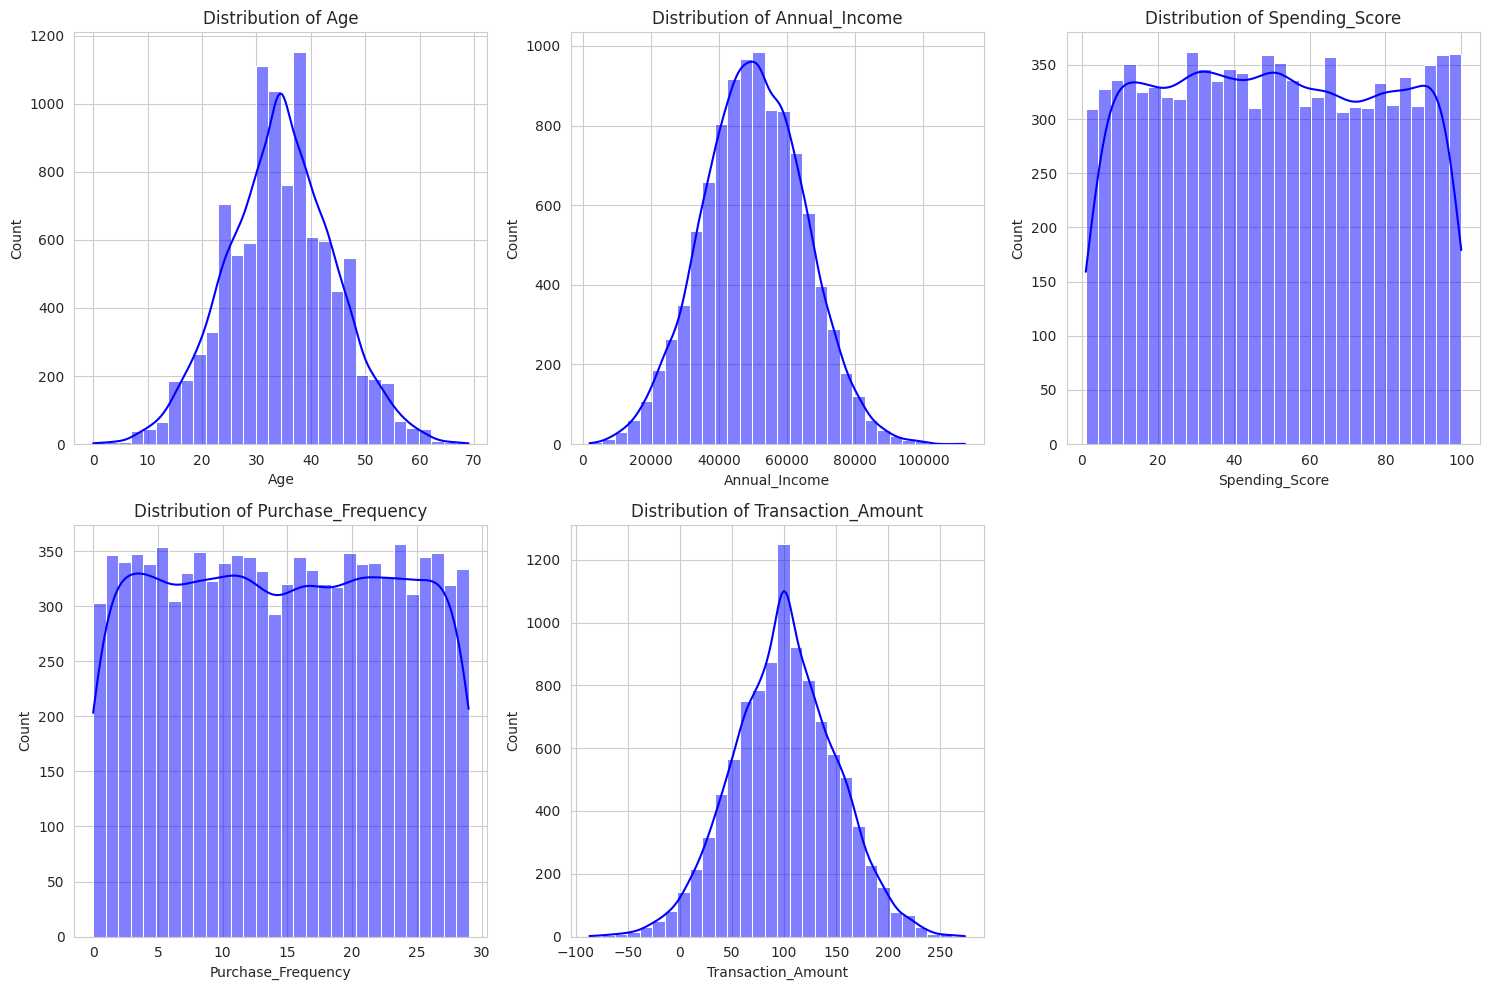


Histograms with outlier analysis


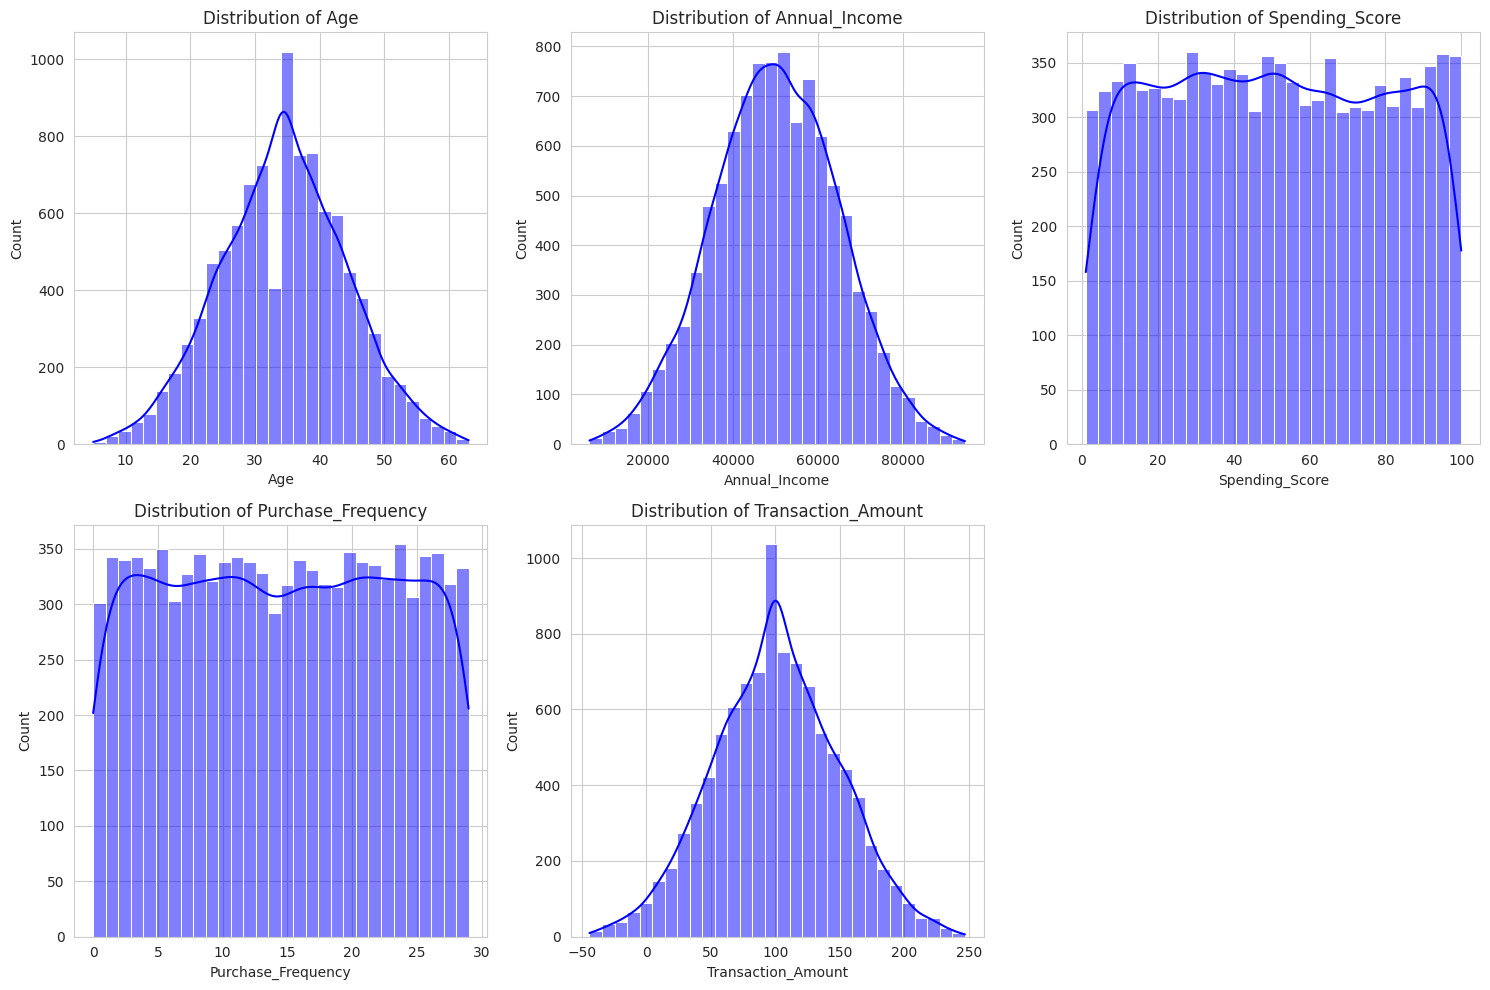


Box Plots without outlier analysis


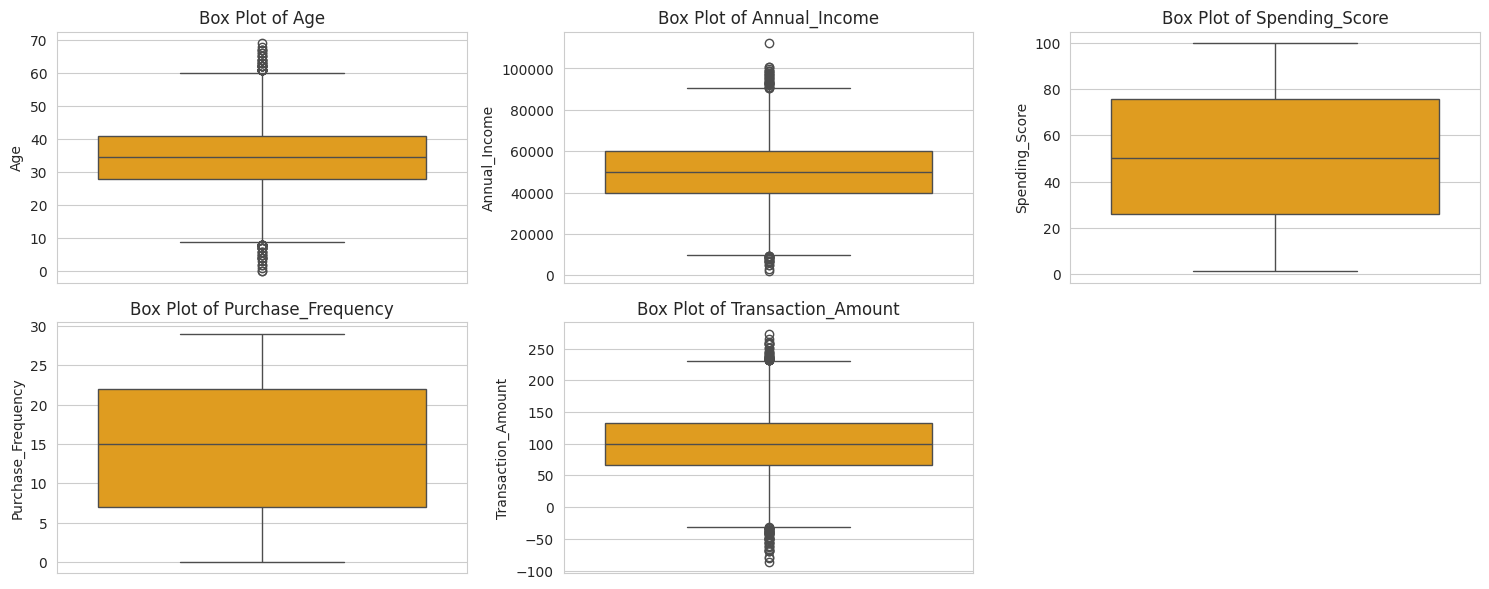


Box Plots with IQR outlier analysis


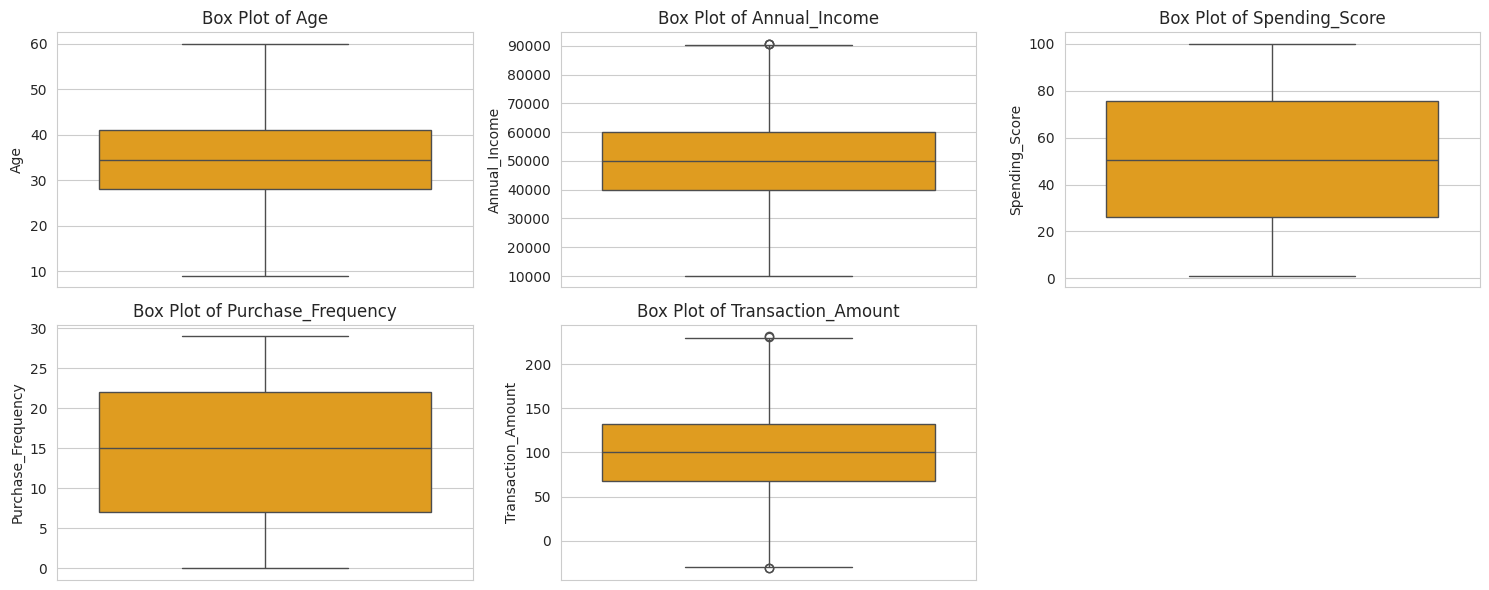


Box Plots with Z-SCORE outlier analysis


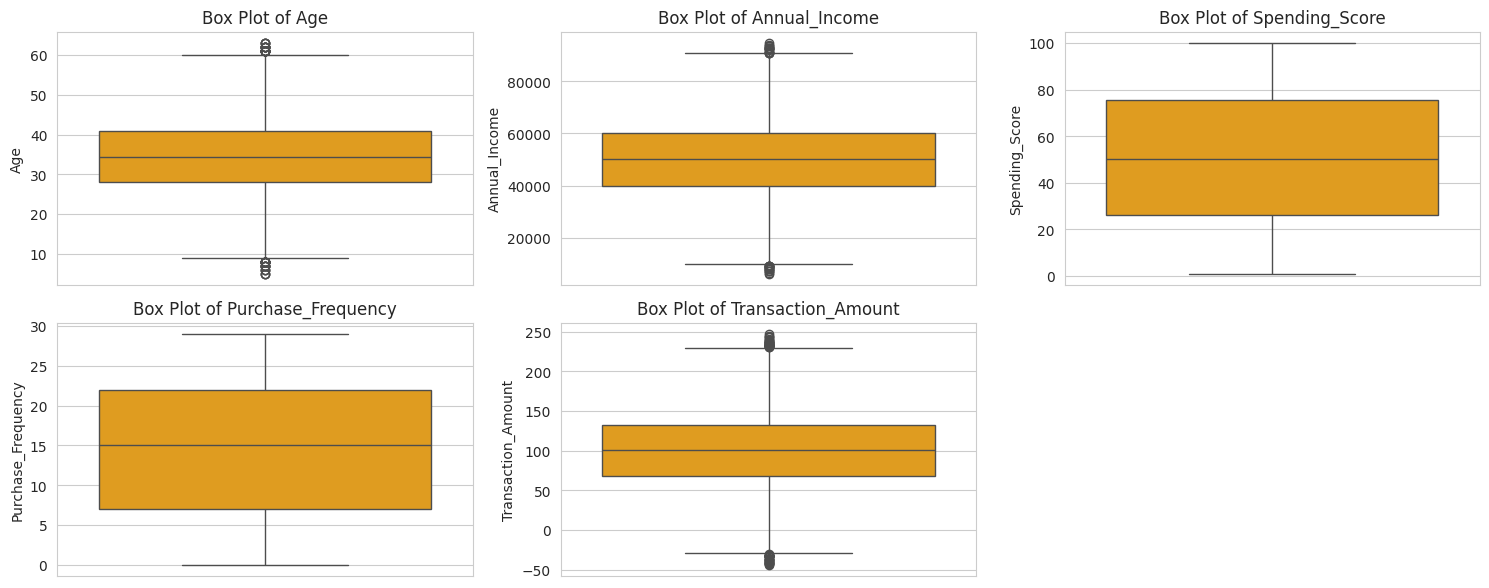

In [86]:
#Note I made plots for data with and without outlier analysis to show the contrast
# Set Seaborn style
sns.set_style("whitegrid")
# 1. UNIVARIATE ANALYSIS

# Summary Statistics without outlier analysis
summary_stats=DB.describe().T  #Transposed for better readability
summary_stats["mode"]=DB.mode().iloc[0]  #Adding mode manually
summary_stats["skewness"]=DB.skew()  #Skewness
summary_stats["kurtosis"]=DB.kurtosis()  #Kurtosis
print("\n Summary Statistics without outlier analysis:\n", summary_stats)

print()

# Summary Statistics with outlier analysis
summary_stats_z=DB_ZSCORE.describe().T  #Transposed for better readability
summary_stats_z["mode"]=DB_ZSCORE.mode().iloc[0]  #Adding mode manually
summary_stats_z["skewness"]=DB_ZSCORE.skew()  #Skewness
summary_stats_z["kurtosis"]=DB_ZSCORE.kurtosis()  #Kurtosis
print("\n Summary Statistics with outlier analysis:\n", summary_stats_z)

print()

# Histograms without outlier analysis
num_cols=["Age", "Annual_Income", "Spending_Score", "Purchase_Frequency", "Transaction_Amount"]
print("Histograms without outlier analysis")
plt.figure(figsize=(15, 10))
for i,col in enumerate(num_cols, 1):
  plt.subplot(2,3,i)
  sns.histplot(DB[col], kde=True, bins=30, color="blue")
  plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

print()

# Histograms with outlier analysis
print("Histograms with outlier analysis")
plt.figure(figsize=(15, 10))
for i,col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(DB_ZSCORE[col], kde=True, bins=30, color="blue")
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

print()

# Box Plots without outlier analysis
print("Box Plots without outlier analysis")
plt.figure(figsize=(15, 6))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=DB[col], color="orange")
    plt.title(f"Box Plot of {col}")
plt.tight_layout()
plt.show()

print()

# Box Plots with IQR outlier analysis
print("Box Plots with IQR outlier analysis")
plt.figure(figsize=(15, 6))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=DB_IQR[col], color="orange")
    plt.title(f"Box Plot of {col}")
plt.tight_layout()
plt.show()

print()

# Box Plots with Z-SCORE outlier analysis
print("Box Plots with Z-SCORE outlier analysis")
plt.figure(figsize=(15, 6))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=DB_ZSCORE[col], color="orange")
    plt.title(f"Box Plot of {col}")
plt.tight_layout()
plt.show()

BIVARIATE ANALYSIS


Correlation Matrix:
                          Age  Annual_Income  Spending_Score  \
Age                 1.000000       0.004971        0.009444   
Annual_Income       0.004971       1.000000        0.002707   
Spending_Score      0.009444       0.002707        1.000000   
Purchase_Frequency -0.015947      -0.007787        0.000617   
Transaction_Amount -0.003477      -0.001545        0.012524   

                    Purchase_Frequency  Transaction_Amount  
Age                          -0.015947           -0.003477  
Annual_Income                -0.007787           -0.001545  
Spending_Score                0.000617            0.012524  
Purchase_Frequency            1.000000            0.012661  
Transaction_Amount            0.012661            1.000000  

Heatmap of Correlations


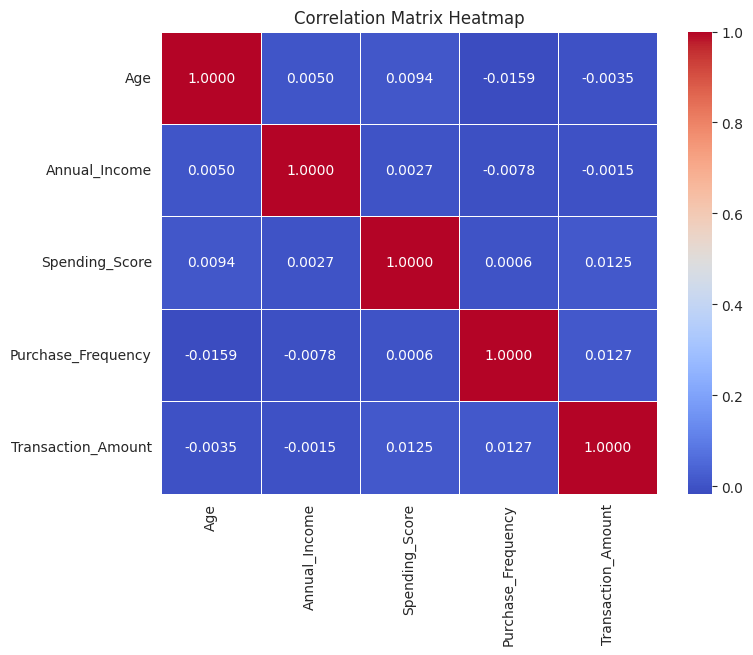

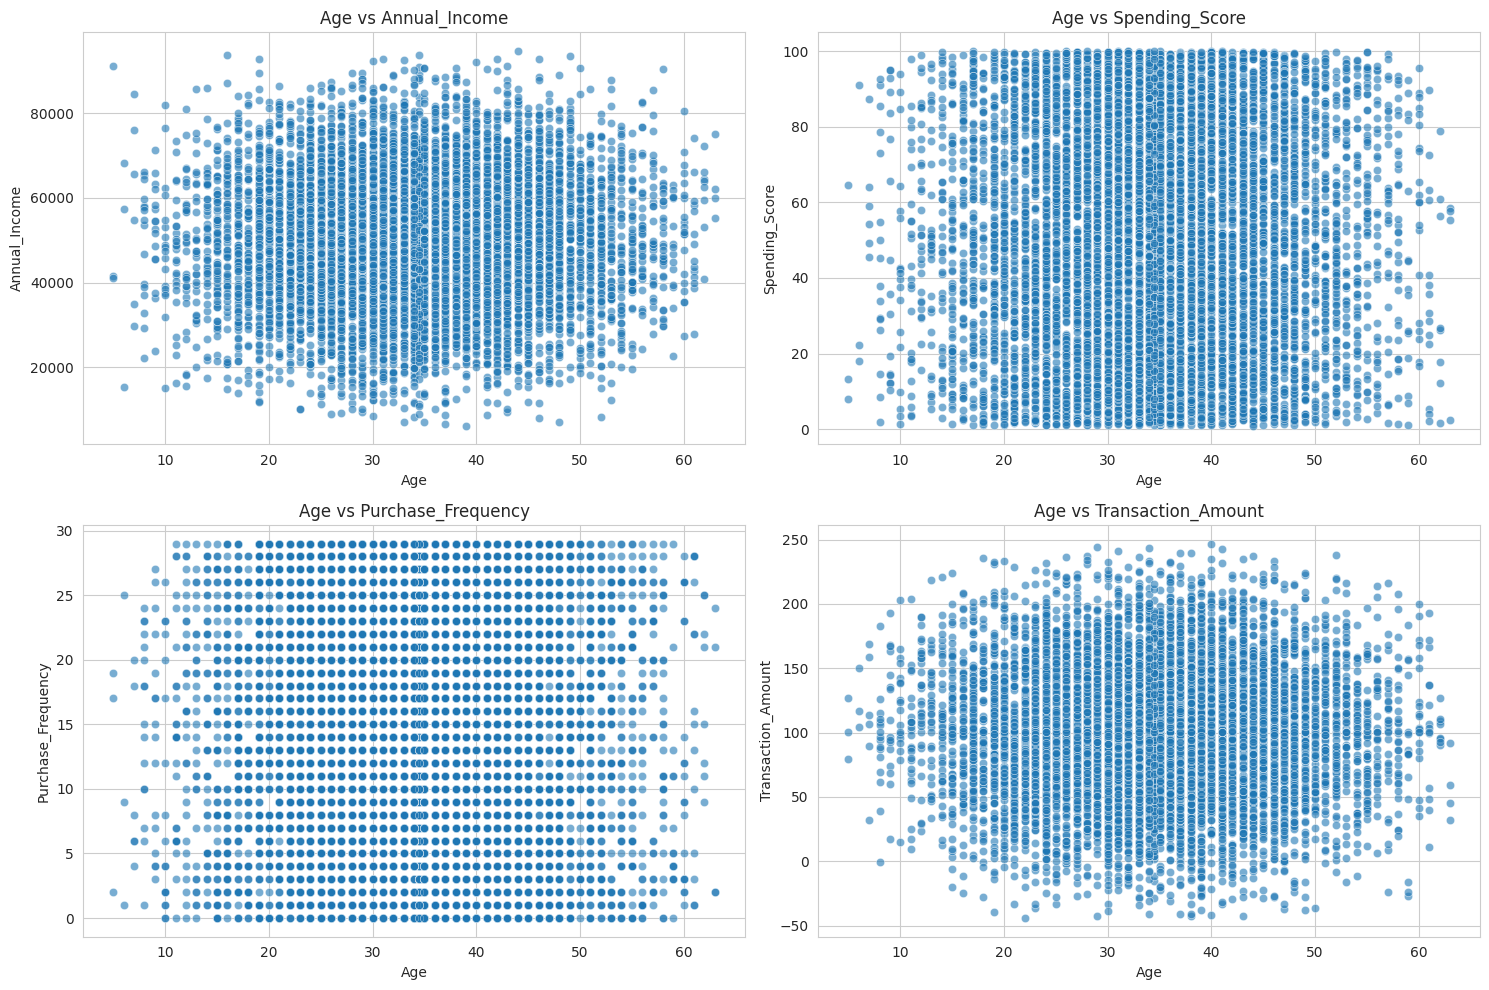

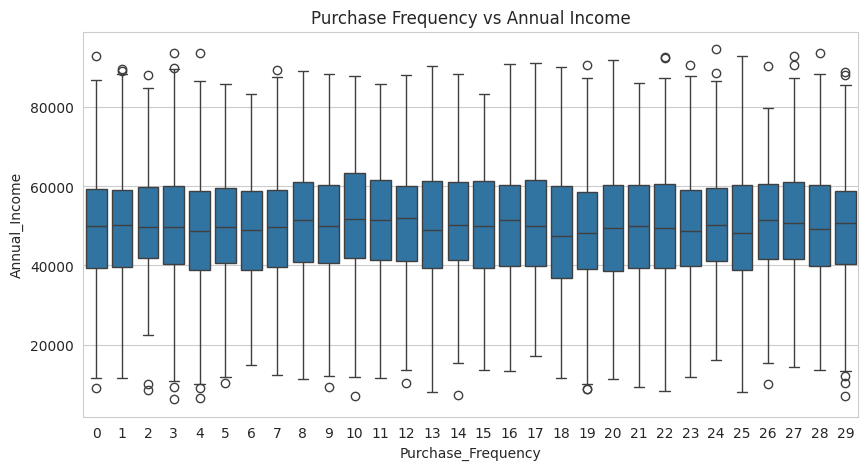

<ipython-input-87-0da9f9d0c4fa>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Purchase_Frequency", y="Transaction_Amount", data=DB_ZSCORE, palette="coolwarm")


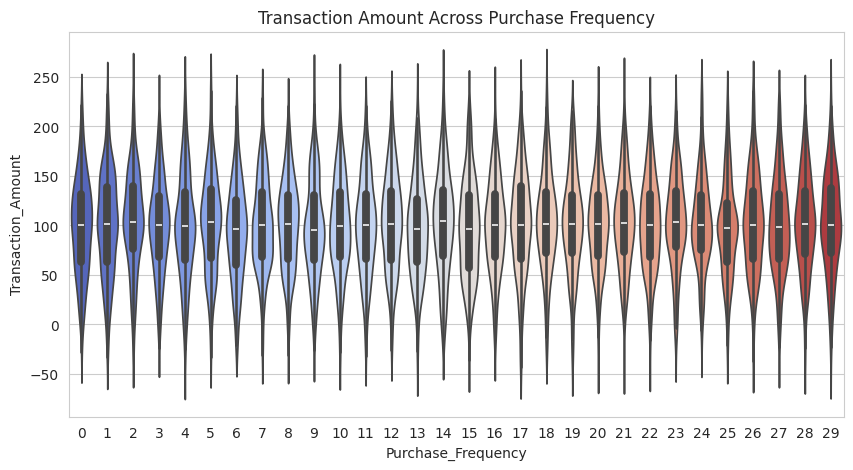

In [87]:
# 2.BIVARIATE ANALYSIS

# Correlation Matrix
corr_matrix=DB_ZSCORE[num_cols].corr()
print("\nCorrelation Matrix:\n", corr_matrix)

print()

# Heatmap of Correlations
print("Heatmap of Correlations")
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".4f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

print()

#Scatter Plots for Relationships
#Skipping 'Age' as X-axis as this bivariate analysis will give meaningful information
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols[1:], 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=DB_ZSCORE["Age"], y=DB_ZSCORE[col], alpha=0.6)
    plt.title(f"Age vs {col}")
plt.tight_layout()
plt.show()

print()

# Box Plot: Categorical vs Numeric
# Given the data selecting Purchase Frequency as Categorical data
# and Annual Income as Numerical data would give meaningful information
plt.figure(figsize=(10, 5))
sns.boxplot(x="Purchase_Frequency", y="Annual_Income", data=DB_ZSCORE)
plt.title("Purchase Frequency vs Annual Income")
plt.show()

print()

# Violin Plot: Distribution of Spending Score across Frequency
# Given the data selecting Purchase Frequency as Categorical data
# and Transaction Amount as Numerical data would give meaningful information
plt.figure(figsize=(10, 5))
sns.violinplot(x="Purchase_Frequency", y="Transaction_Amount", data=DB_ZSCORE, palette="coolwarm")
plt.title("Transaction Amount Across Purchase Frequency")
plt.show()

MULTIVARIATE ANALYSIS

This is the Pairplot Analysis


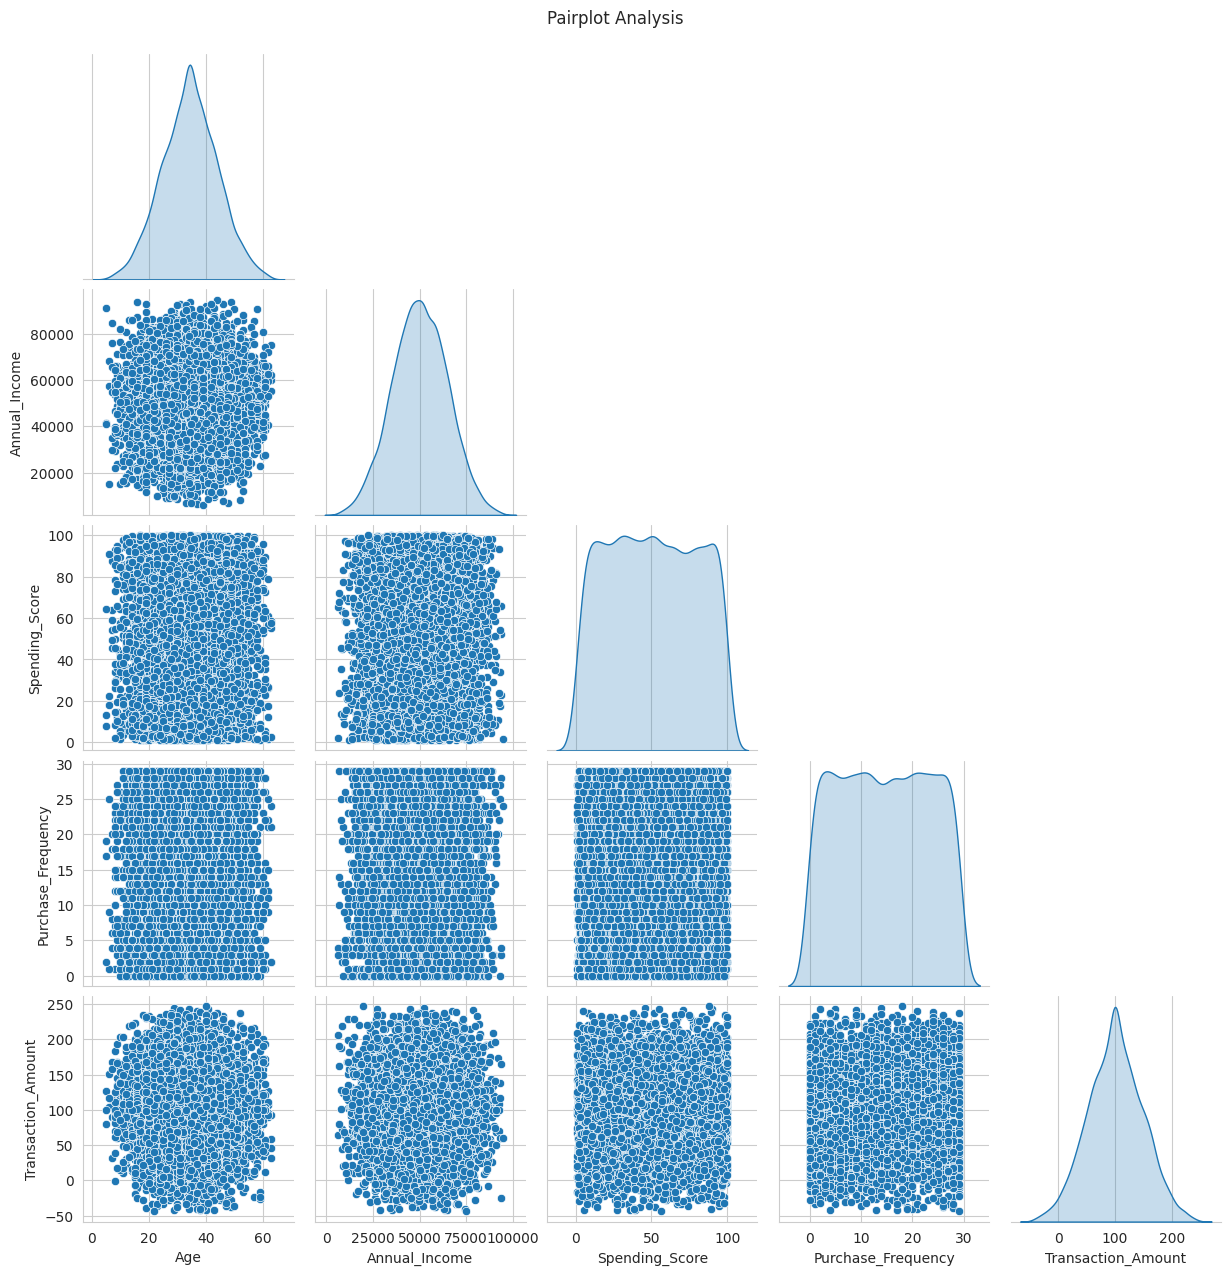


This is the Heatmap of Feature Relationships


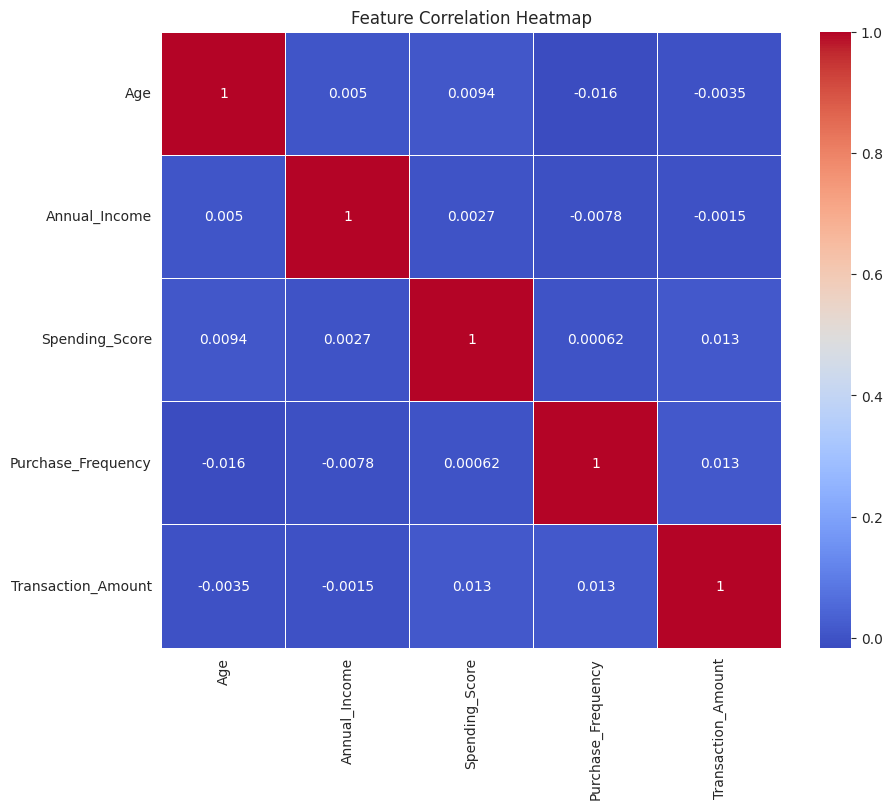



 Grouped Mean Values:
                     Spending_Score  Annual_Income  Transaction_Amount
Purchase_Frequency                                                   
0                        51.684358   50045.752075           98.974487
1                        51.052377   49978.506088          100.783301
2                        52.704898   51054.323016          104.698250
3                        50.262386   50252.006799           99.036794
4                        50.148467   49117.368817           99.472479
5                        50.687722   50000.113317          101.744815
6                        48.898173   48819.600267           93.320191
7                        52.861980   49933.597368          100.238035
8                        46.532629   51106.711527          100.535655
9                        50.209137   49993.716660           97.721895
10                       49.341880   52200.292780           98.939133
11                       48.393118   50844.371424           99.34

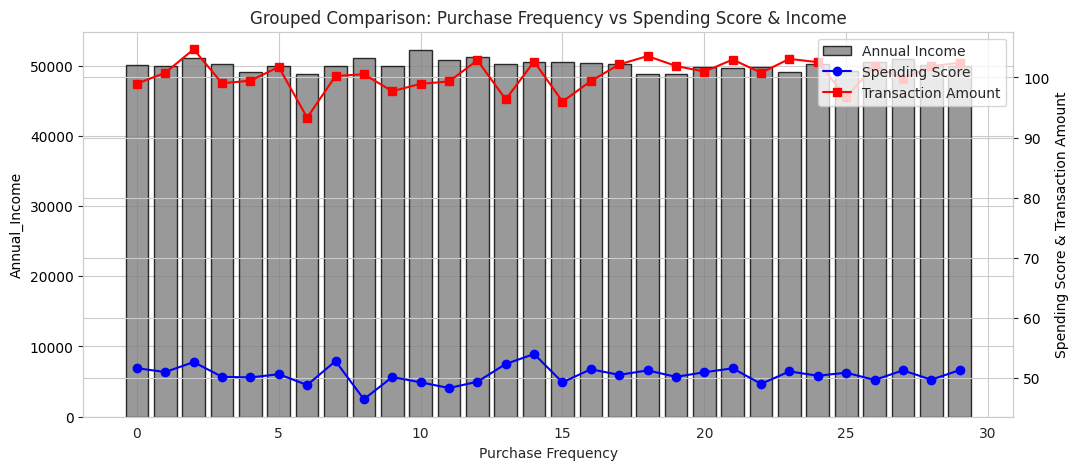

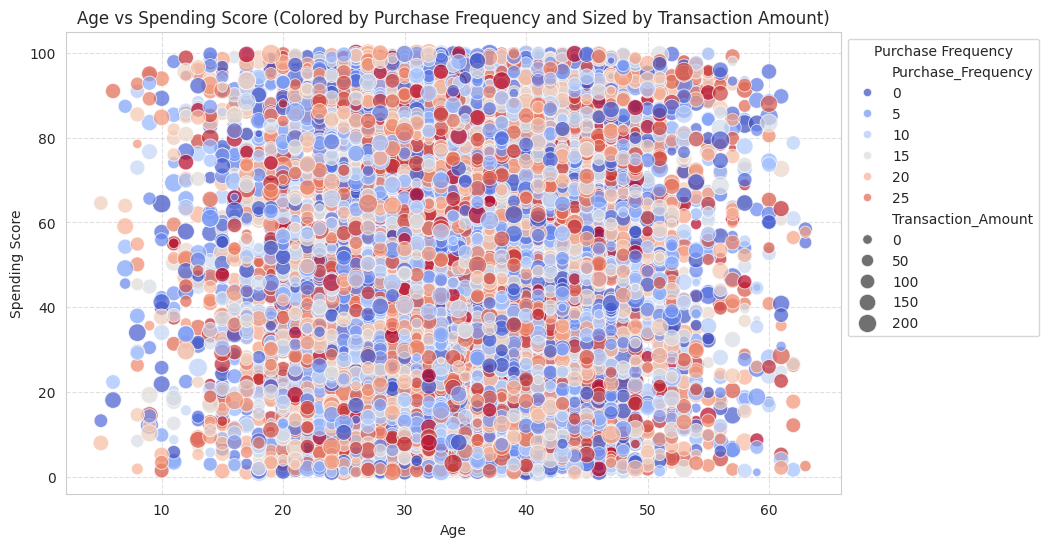

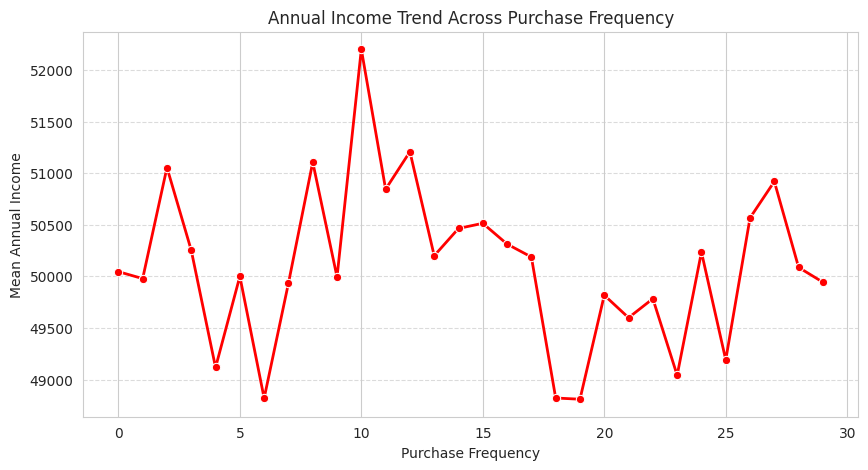

In [88]:
# 3. MULTIVARIATE ANALYSIS
#Pair Plot
print("This is the Pairplot Analysis")
sns.pairplot(DB_ZSCORE[num_cols], diag_kind="kde", corner=True)
plt.suptitle("Pairplot Analysis", y=1.02)
plt.show()

print()

#Heatmap of Feature Relationships
print("This is the Heatmap of Feature Relationships")
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix,annot=True,cmap="coolwarm",linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()



print()



#Grouped Analysis: Mean Spending Score and Annual Income by Purchase Frequency
grouped_data = DB_ZSCORE.groupby("Purchase_Frequency")[["Spending_Score", "Annual_Income", "Transaction_Amount"]].mean()
print("\n Grouped Mean Values:\n", grouped_data)



print()



# 1. Grouped Bar Plot: Purchase Frequency vs Mean Spending Score & Income
fig,axisleft=plt.subplots(figsize=(12, 5))

# Bar plot for Annual Income (since it's large)
axisleft.bar(grouped_data.index, grouped_data["Annual_Income"], color="gray", alpha=0.8, edgecolor="black", label="Annual Income")
axisleft.set_ylabel("Annual_Income", color="black")
axisleft.tick_params(axis="y", labelcolor="black")

# Create secondary Y-axis
axisright=axisleft.twinx()

# Line plots for Spending Score & Transaction Amount (since they are smaller)
axisright.plot(grouped_data.index, grouped_data["Spending_Score"], color="blue", marker="o", label="Spending Score")
axisright.plot(grouped_data.index, grouped_data["Transaction_Amount"], color="red", marker="s", label="Transaction Amount")
axisright.set_ylabel("Spending Score & Transaction Amount", color="black")
axisright.tick_params(axis="y", labelcolor="black")

# Titles and labels
plt.title("Grouped Comparison: Purchase Frequency vs Spending Score & Income")
axisleft.set_xlabel("Purchase Frequency")

# Combine legends
handles1,labels1=axisleft.get_legend_handles_labels()
handles2,labels2=axisright.get_legend_handles_labels()
axisright.legend(handles1 + handles2, labels1 + labels2, loc="upper right")
plt.show()



print()




# 2. Interaction Between Age, Spending Score & Purchase Frequency
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Age", y="Spending_Score", hue="Purchase_Frequency", size="Transaction_Amount",
                data=DB_ZSCORE, palette="coolwarm", alpha=0.7, sizes=(20,200))
plt.title("Age vs Spending Score (Colored by Purchase Frequency and Sized by Transaction Amount)")
plt.xlabel("Age")
plt.ylabel("Spending Score")
plt.legend(title="Purchase Frequency", bbox_to_anchor=(1, 1))
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()



print()




# 3. Line Plot: Purchase Frequency vs Mean Annual Income
plt.figure(figsize=(10, 5))
sns.lineplot(x=grouped_data.index, y=grouped_data["Annual_Income"], marker="o", color="red", linewidth=2)
plt.title("Annual Income Trend Across Purchase Frequency")
plt.xlabel("Purchase Frequency")
plt.ylabel("Mean Annual Income")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()